# Tiempos:
- Sin EDA
- Preprocessing basico
- train test split: 1h

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from utility_funcs import *
import xgboost as xgb

## 1. Lectura y preprocesamiento de datos

In [2]:
demanda_df = pd.read_csv(".\Datos\demanda.csv")

In [3]:
demanda_prod_df = demanda_df[demanda_df['id_producto']==1]
demanda_prod_df.drop(columns=['id_producto'], inplace=True)
demanda_prod_df['date'] = pd.to_datetime(demanda_prod_df['date'], format='%Y-%m-%d')

# Primero, asegurar que todas las fechas estan
# Los datos de demanda iniciales no tienen enero 2020
fecha_inicial = pd.to_datetime('2020-01-01')
fechas_df = pd.DataFrame({'date': pd.date_range(start=fecha_inicial, end=demanda_prod_df['date'].max())})
complete_demanda_prod_df = fechas_df.merge(demanda_prod_df
                                           ,how='left'
                                           ,left_on='date'
                                           ,right_on='date'
                                           )

C:\Users\juanc\AppData\Local\Temp\ipykernel_6808\2870044259.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  demanda_prod_df.drop(columns=['id_producto'], inplace=True)
C:\Users\juanc\AppData\Local\Temp\ipykernel_6808\2870044259.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  demanda_prod_df['date'] = pd.to_datetime(demanda_prod_df['date'], format='%Y-%m-%d')


In [4]:
# Preprocesamiento de la serie de tiempo
complete_demanda_prod_df['demanda'].ffill(inplace=True)
complete_demanda_prod_df['demanda'].bfill(inplace=True)


# Eliminacion de 29 de febrero.
complete_demanda_prod_df = complete_demanda_prod_df.sort_values(by='date', ascending=True)

C:\Users\juanc\AppData\Local\Temp\ipykernel_6808\1117770948.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  complete_demanda_prod_df['demanda'].ffill(inplace=True)
C:\Users\juanc\AppData\Local\Temp\ipykernel_6808\1117770948.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

In [5]:
# Generacion de variables exogenas
exog_vars_dict = generate_exogenous(complete_demanda_prod_df['date'].min(), complete_demanda_prod_df.shape[0])
exog_vars_df = pd.DataFrame(exog_vars_dict)
exog_vars_df['date'] = complete_demanda_prod_df['date']

### Obtener los lags necesarios, errores (con medias moviles) y diferenciacion si es necesario
- Mejores parametros (2,1, q), `q` por determinar

In [6]:
# Los mejores lags
complete_demanda_prod_df['demanda_lag_1'] = complete_demanda_prod_df['demanda'].shift(1)
complete_demanda_prod_df['demanda_lag_2'] = complete_demanda_prod_df['demanda'].shift(2)

In [7]:
# Diferenciacion de primer grado
complete_demanda_prod_df['demanda_diff_1'] = complete_demanda_prod_df['demanda'] - complete_demanda_prod_df['demanda_lag_1']

In [8]:
# Eliminacion de valores faltantes
df = complete_demanda_prod_df.dropna(subset=['demanda', 'demanda_lag_1', 'demanda_lag_2', 'demanda_diff_1'], inplace=False)

In [9]:
# inclusion de media movil:
df['rolling_mean_7'] = df['demanda'].shift(1).rolling(window=7).mean()
df['rolling_trend'] = df['demanda'].shift(1) - df['rolling_mean_7']


C:\Users\juanc\AppData\Local\Temp\ipykernel_6808\4021482756.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['rolling_mean_7'] = df['demanda'].shift(1).rolling(window=7).mean()
C:\Users\juanc\AppData\Local\Temp\ipykernel_6808\4021482756.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['rolling_trend'] = df['demanda'].shift(1) - df['rolling_mean_7']


In [10]:
# Calcular pendiente local usando regresión lineal en ventana móvil
from sklearn.linear_model import LinearRegression

def rolling_slope(series, window=14):
    slopes = []
    for i in range(len(series)):
        if i < window:
            slopes.append(np.nan)
        else:
            y = series[i-window:i].values.reshape(-1, 1)
            x = np.arange(window).reshape(-1, 1)
            reg = LinearRegression().fit(x, y)
            slopes.append(reg.coef_[0][0])
    return slopes

df['rolling_slope_14'] = rolling_slope(df['demanda'], window=14)


C:\Users\juanc\AppData\Local\Temp\ipykernel_6808\114366901.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['rolling_slope_14'] = rolling_slope(df['demanda'], window=14)


### Normalizacion de los datos

In [11]:
# Para evaluar despues

### Unificacion entre variables de la variable endogena y exogenas

In [12]:
full_data_df = df.merge(exog_vars_df ,how='left' ,left_on='date' ,right_on='date', suffixes=('_endog', '_exog'))

In [13]:
full_data_df.columns

Index(['date', 'demanda', 'demanda_lag_1', 'demanda_lag_2', 'demanda_diff_1',
       'rolling_mean_7', 'rolling_trend', 'rolling_slope_14',
       'es_fin_de_semana', 'is_feb_29', 'mes_sin', 'mes_cos', 'dia_sin',
       'dia_cos', 'dia_de_semana_sin', 'dia_de_semana_cos',
       'flg_despues_llegada_competencia'],
      dtype='object')

## 2. Entrenamiento del modelo

In [14]:
flg_diff = False
flg_rolling_trend = True
if not flg_diff:
    full_data_df.drop(columns=[c for c in full_data_df.columns if 'diff' in c], axis=1, inplace=True)
    
if flg_rolling_trend:
    full_data_df.drop(columns=['rolling_mean_7'], axis=1, inplace=True)
else:
    full_data_df.drop(columns=[c for c in full_data_df.columns if 'rolling' in c], axis=1, inplace=True)

In [15]:
# Separacion de datos entre train y test
test_size = 0.2
train_df = full_data_df.iloc[:int(full_data_df.shape[0]*(1-test_size)), :]
X_train = train_df.drop(columns=['date', 'demanda'])
y_train = train_df['demanda']

test_df = full_data_df.iloc[int(full_data_df.shape[0]*(1-test_size)):, :]
X_test = test_df.drop(columns=['date', 'demanda'])
y_test = test_df['demanda']

In [16]:
# Entrenamiento de modelo XGBoost
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train, verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=None, num_parallel_tree=None, ...)

<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

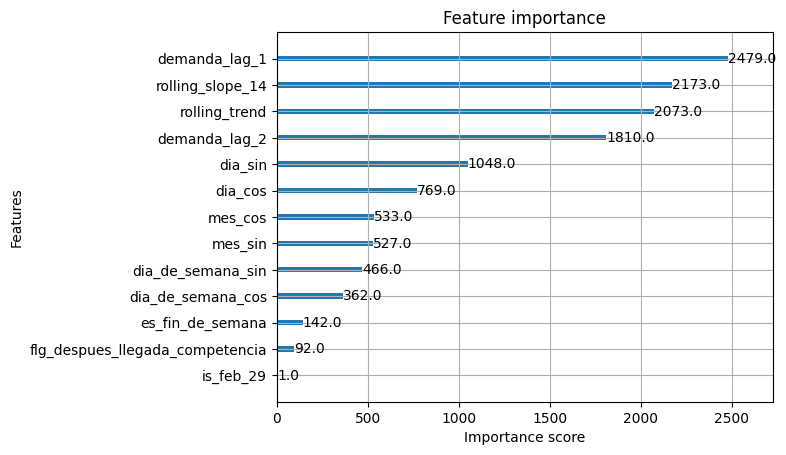

In [17]:
xgb.plot_importance(reg)

In [18]:
test_df['demanda_pred'] = reg.predict(X_test)

C:\Users\juanc\AppData\Local\Temp\ipykernel_6808\194966177.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['demanda_pred'] = reg.predict(X_test)


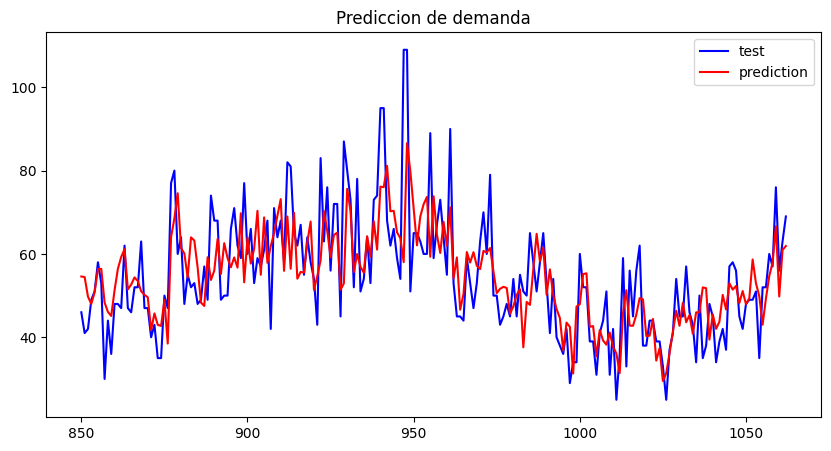

In [19]:
#train_df['demanda'].plot(style='k', figsize=(10,5), label = 'train')
test_df['demanda'].plot(style='b', figsize=(10,5), label = 'test')
test_df['demanda_pred'].plot(style='r', figsize=(10,5), label = 'prediction')
plt.title('Prediccion de demanda')
plt.legend()

### 3. Evaluacion de metricas del modelo

In [20]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

In [21]:
#print('RMSE: ', round(np.sqrt(np.sum((test_df['demanda_pred'] - test_df['demanda'])**2)), 3))
print('RMSE: ', round(np.sqrt(mean_squared_error(y_true=test_df['demanda'],y_pred=test_df['demanda_pred'])),3))
print('MAE: ', round(mean_absolute_error(y_true=test_df['demanda'],y_pred=test_df['demanda_pred']),3))
print('MAPE: ', round(mean_absolute_percentage_error(y_true=test_df['demanda'],y_pred=test_df['demanda_pred']),3))

RMSE:  10.351
MAE:  7.843
MAPE:  0.146


## Exportacion de modelo

In [22]:
import json
import pickle

In [26]:
model_name = "xgboost_demand_forecast_with_exogenous-0.1.0.pkl"
#joblib.dump(modelo_arima, model_name)
# Guarda el modelo en un archivo
with open('./' + model_name, 'wb') as f:
    pickle.dump(reg, f)

In [24]:
X_train.columns

Index(['demanda_lag_1', 'demanda_lag_2', 'rolling_trend', 'rolling_slope_14',
       'es_fin_de_semana', 'is_feb_29', 'mes_sin', 'mes_cos', 'dia_sin',
       'dia_cos', 'dia_de_semana_sin', 'dia_de_semana_cos',
       'flg_despues_llegada_competencia'],
      dtype='object')